# Topic Modelling

### Import Libraries and Datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

import regex as re
from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from textblob import Word

from wordcloud import WordCloud

import gensim, spacy
import gensim.corpora as corpora
from gensim.models import CoherenceModel
import pyLDAvis.gensim_models
from pprint import pprint

pd.set_option('display.max_columns', None)
style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

/opt/anaconda3/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [205]:
res = pd.read_csv('../data/restaurants.csv')
rev = pd.read_csv('../data/reviews_clean.csv')

1736 restaurants have undescriptive categories

In [343]:
res[res['category']=='Restaurant']['title'].count()

1736

In [3]:
rev.head()

,title,placeid,revname,revid,revdate,revtext,stars,cleantext,wordcount
0,Shang Palace,ChIJXU9FcvQZ2jER7JzFxTOvf9A,W San L,104193174503991545162,2021-03-15,The dishes were delicious and the service staf...,5.0,dish delicious service staff attentive maybe d...,20.0
1,Shang Palace,ChIJXU9FcvQZ2jER7JzFxTOvf9A,Chiwa C,113235938724027892276,2021-03-31,The service was impeccable. I came with my mom...,5.0,service impeccable came mom saturday fall 15th...,43.0
2,Shang Palace,ChIJXU9FcvQZ2jER7JzFxTOvf9A,George Seah,114261243006797437214,2021-05-09,Great food. Great service. Have tried shang pa...,5.0,great food great service tried shang palace be...,20.0
3,Shang Palace,ChIJXU9FcvQZ2jER7JzFxTOvf9A,MH lai,112309749743390038824,2021-04-10,We enjoyed Hk dim sum here . We definitely wi...,4.0,enjoyed hk dim sum definitely come back,7.0
4,Shang Palace,ChIJXU9FcvQZ2jER7JzFxTOvf9A,Paladin LT,114155819585951030381,2021-05-04,Went to experience their 50th anniversary cele...,2.0,went experience 50th anniversary celebratory m...,106.0


Joining all reviews for each restaurant together as a document for that restaurant 

In [4]:
resrev_rev = rev.groupby('placeid')['revtext'].agg(lambda x : ' '.join(x)).reset_index().set_index('placeid')

In [5]:
resrev_title = rev.groupby('placeid')['title'].first().reset_index().set_index('placeid')

In [6]:
resrev = pd.concat([resrev_title, resrev_rev,], axis=1)

In [7]:
resrev.head()

,title,revtext
placeid,,
ChIJ--SL2o0a2jERtOpNIBfE8Uk,McDonald's,One of the better McDonald’s outlets in Singap...
ChIJ--hkAgc52jERqpXGVM4S2u4,Cookhouse 2,"They say that in the army,\nThe food is very n..."
ChIJ-0DAQI4a2jERVIPajSdgj58,Sichuan Tianfu Restaurant 天府川菜,pleasant and authentic dining experience with ...
ChIJ-0EGncc82jER1vuh2kbG8HQ,McDonald's Terminal 4,Great to also have this fast food chain in Cha...
ChIJ-0dfsqYX2jERKJ2wZmoP4bw,The Ship Restaurant & Bar (Nex Outlet),Celebrated colleague’s birthday dinner here. S...


In [8]:
resrev['revtext'][0]

'One of the better McDonald’s outlets in Singapore. Tucked away from the busy Clementi Mall, quiet place and usually not very crowded. The employees there are also great. Around 30 mins after realising my order was not complete I went back and asked them for it and the cashier remembered who I was and gave me the correct order. Friendly & polite staff who are willing to help. Small area to eat in, not exactly cold inside also. This mcds seems to cater more for takeaways Order chocolate pies to take away.\nWait 13 minutes is still not done yet. Miss my bus to work!\nDecide to cancel it. If not, I am going to miss another bus to work!\nToo bad. I miss my chocolate pie! Smaller Mcdonalds in terms of seating. But they do have the full menu.\n\nAlso expect lines here normally at all times mainly due to how much delivery they do in the area. If you want more seating there is anoter Mcdonalds at clementi mall. Hey could you step up on the hygiene. And people who ate, clean up after yourself i

### Text Cleaning

In [354]:
texts = resrev.revtext.values.tolist()

In [355]:
def preprocess(texts):
    """
    Inputs: Text
    Outputs: Text as list of words with punctuation and special characters removed
    """
    for text in texts:
        text = re.sub('\s+', ' ', text) # Remove additional spaces
        text = re.sub("\'", "", text) #Remove \' character
        text = gensim.utils.simple_preprocess(str(text), deacc=True) 
        yield(text)

In [11]:
texts_list = list(preprocess(texts))

In [12]:
def lemmatize(texts):
    """
    Inputs: Text as list
    Outputs: Lemmatized text with stopwords removed, keeping on nouns and adjectives.
    """
    texts_lemma = []
    stop_words = stopwords.words('english')
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
    allowed_postags = ['NOUN', 'ADJ']
    for text in texts:
        text_lemma = nlp(" ".join(text))     
        texts_lemma.append([token.lemma_ for token in text_lemma if token.text not in stop_words and token.pos_ in allowed_postags])
    return texts_lemma

In [13]:
texts_lemma = lemmatize(texts_list)

In [14]:
def bigrams(texts):
    """
    Inputs: Text
    Outputs: Text with common bigrams merged as a bigram
    """
    bigram_phrases = gensim.models.Phrases(texts,
                                            min_count=5,
                                            threshold=25) 
    bigram_model = gensim.models.phrases.Phraser(bigram_phrases)

    return [bigram_model[text] for text in texts]

In [15]:
texts_bigrams = bigrams(texts_lemma)

In [16]:
def trigram(texts):
    """
    Inputs: Text
    Outputs: Text with common trigrams merged as a trigram
    """
    trigram_phrases = gensim.models.Phrases(texts,
                                            min_count=5,
                                            threshold=25) 
    trigram_model = gensim.models.phrases.Phraser(trigram_phrases)

    return [trigram_model[text] for text in texts]

In [17]:
texts_trigrams = trigram(texts_bigrams)

In [18]:
print(texts_trigrams[0])

['well', 'mcdonald', 'outlet', 'singapore', 'busy', 'clementi_mall', 'quiet', 'place', 'crowded', 'employee', 'great', 'min', 'order', 'complete', 'cashier', 'correct', 'order', 'friendly', 'polite', 'staff', 'willing', 'small', 'area', 'cold', 'mcds', 'takeaway', 'chocolate', 'pie', 'minute', 'bus', 'bus', 'bad', 'chocolate', 'pie', 'small', 'mcdonald', 'term', 'seating', 'full', 'menu', 'line', 'time', 'much', 'delivery', 'area', 'seating', 'anoter', 'mcdonald', 'clementi_mall', 'hygiene', 'people', 'clean', 'little', 'seating', 'available', 'space', 'small', 'convenient', 'main', 'bus_stop', 'next', 'court', 'building', 'entrance', 'service', 'professional', 'polite', 'friendly', 'staff', 'staff', 'outlet', 'day', 'peak_hour', 'morning', 'certain', 'promotion', 'meal', 'fruit', 'fly', 'black', 'bird', 'restaurant', 'place', 'meal', 'service', 'crew', 'counter', 'helpful', 'polite', 'slow', 'mcd', 'singapore', 'bad', 'store', 'manager', 'staff', 'nd', 'counter', 'kitchen', 'sweet', '

## Modelling

In [19]:
id2word = corpora.Dictionary(texts_trigrams)

corpus = [id2word.doc2bow(text) for text in texts_trigrams]

In [358]:
def ldascore(k):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=k,
                                            random_state=42,
                                            chunksize=250,
                                            passes=5,
                                            alpha='auto',
                                            iterations=10,
                                            per_word_topics=False)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=texts_trigrams, dictionary=id2word, coherence='c_v')
    coherence_lda = round(coherence_model_lda.get_coherence(),3)
    print(f'K: {k} Model Coherence Score: {coherence_lda}')
    return coherence_lda

In [359]:
coherence_results = {}
for i in range(3, 11, 1):
    coherence_results[i] = ldascore(i)

K: 3 Model Coherence Score: 0.296
K: 4 Model Coherence Score: 0.307
K: 5 Model Coherence Score: 0.306
K: 6 Model Coherence Score: 0.309
K: 7 Model Coherence Score: 0.313
K: 8 Model Coherence Score: 0.316
K: 9 Model Coherence Score: 0.317
K: 10 Model Coherence Score: 0.321


In [361]:
for i in range(11, 16, 1):
    coherence_results[i] = ldascore(i)

K: 11 Model Coherence Score: 0.325
K: 12 Model Coherence Score: 0.339
K: 13 Model Coherence Score: 0.321
K: 14 Model Coherence Score: 0.333
K: 15 Model Coherence Score: 0.335


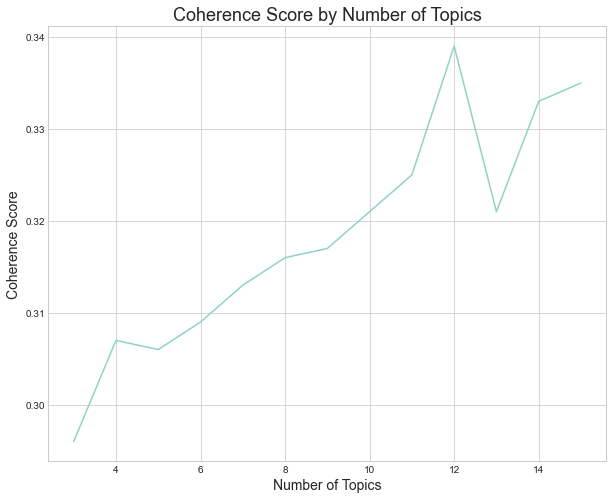

In [362]:
plt.figure(figsize=(10,8))
sns.lineplot(x=coherence_results.keys(), y=coherence_results.values())
plt.xlabel("Number of Topics", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title("Coherence Score by Number of Topics", fontsize=18)
plt.savefig('../images/coherence.png', dpi = 150, bbox_inches='tight', facecolor='w')
plt.show()

As 12 has the highest coherence score for the number of topics, to use 12 topics

In [20]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                        id2word=id2word,
                                        num_topics=12,
                                        random_state=42,
                                        chunksize=250,
                                        passes=5,
                                        alpha='auto',
                                        iterations=10,
                                        per_word_topics=False)

In [21]:
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.029*"good" + 0.028*"coffee" + 0.025*"staff" + 0.025*"place" + '
  '0.019*"nice" + 0.017*"service" + 0.014*"cafe" + 0.013*"friendly" + '
  '0.013*"breakfast" + 0.013*"ice_cream"'),
 (1,
  '0.087*"food" + 0.068*"place" + 0.061*"good" + 0.044*"nice" + 0.037*"great" '
  '+ 0.018*"drink" + 0.015*"friendly" + 0.014*"price" + 0.013*"staff" + '
  '0.012*"ambience"'),
 (2,
  '0.076*"food" + 0.059*"good" + 0.034*"curry" + 0.032*"prata" + '
  '0.027*"indian" + 0.020*"place" + 0.016*"restaurant" + 0.015*"chicken" + '
  '0.014*"nice" + 0.014*"taste"'),
 (3,
  '0.038*"chicken" + 0.038*"food" + 0.031*"order" + 0.028*"service" + '
  '0.025*"time" + 0.025*"staff" + 0.021*"bad" + 0.019*"customer" + '
  '0.016*"good" + 0.014*"outlet"'),
 (4,
  '0.070*"service" + 0.065*"food" + 0.043*"staff" + 0.042*"good" + '
  '0.017*"restaurant" + 0.016*"great" + 0.014*"friendly" + 0.014*"table" + '
  '0.013*"quality" + 0.013*"time"'),
 (5,
  '0.046*"food" + 0.045*"dish" + 0.043*"good" + 0.020*"fish" + 0.018*

In [363]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.073600  0.103010       1        1  13.521649
4      0.120489 -0.033466       2        1  13.020667
10     0.086014 -0.149655       3        1  12.243325
1      0.114787  0.047735       4        1  10.474962
5     -0.082373 -0.021822       5        1   8.919059
6     -0.169710 -0.034619       6        1   8.132539
11    -0.101550  0.177394       7        1   6.595173
7     -0.005132 -0.108705       8        1   6.496419
0      0.161181  0.063906       9        1   6.354131
9     -0.100257 -0.031026      10        1   6.069797
2     -0.051666  0.057615      11        1   4.262436
8     -0.045382 -0.070368      12        1   3.909843, topic_info=           Term           Freq          Total Category  logprob  loglift
73         food  112918.000000  112918.000000  Default  30.0000  30.0000
254        soup   13622.000000   13622.000000  Default  29.0000  29.0000
320        dish   23460.000000   23460.000000  Default  28.0000  28.0000
226     chicken   24927.000000   24927.000000  Default  27.0000  27.0000
152       place   39244.000000   39244.000000  Default  26.0000  26.0000
..          ...            ...            ...      ...      ...      ...
206        time     657.962421   26258.136082  Topic12  -4.9955  -0.4449
115        meal     592.202308   12254.942364  Topic12  -5.1008   0.2118
184       small     572.309104    9417.943150  Topic12  -5.1350   0.4410
512       worth     521.047662    9075.970716  Topic12  -5.2288   0.3841
433  reasonable     507.169228    7397.996270  Topic12  -5.2558   0.5616

[924 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
4330     12  0.988533        aburi
6078      2  0.980102  adult_child
273       1  0.020279   affordable
273       2  0.018749   affordable
273       4  0.149989   affordable
...     ...       ...          ...
5084      5  0.993101     zhi_char
2655      5  0.885896      zi_char
2655      7  0.111026      zi_char
3817      6  0.980170          小笼包
9846      2  0.983490           너무

[2668 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 5, 11, 2, 6, 7, 12, 8, 1, 10, 3, 9])

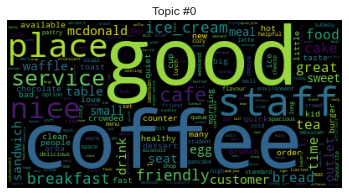

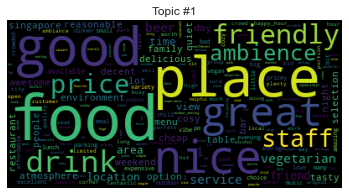

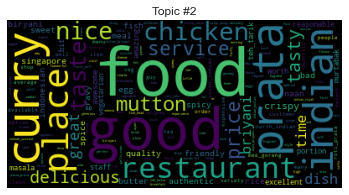

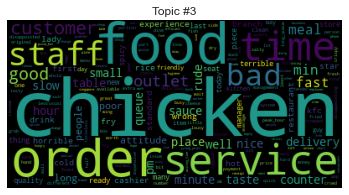

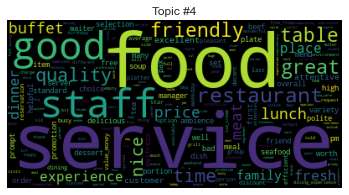

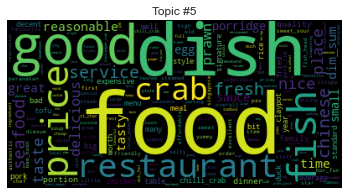

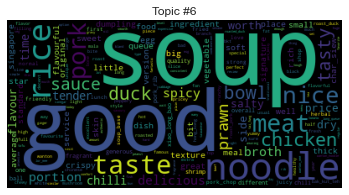

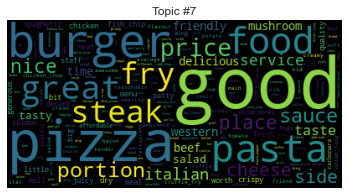

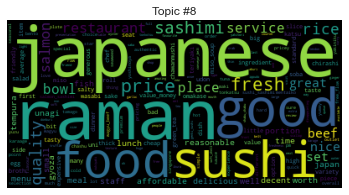

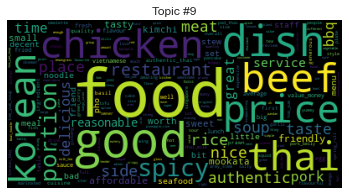

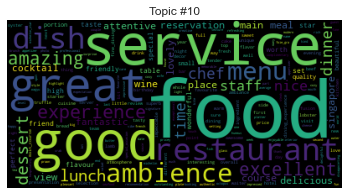

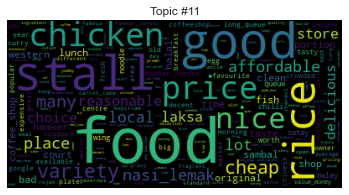

In [366]:
# Generating wordclouds
for t in range(lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    path = '../images/topic' + str(t) + '.png'
    plt.savefig(path, dpi = 150, bbox_inches='tight', facecolor='w')
    plt.show()

In [196]:
def get_topics_df(ldamodel, corpus, texts):
    """
    Inputs: The LDA model, the corpus and the texts
    Outputs: Dataframe of restaurants with assigned topic and top 30 keywords for each topic
    """
    # Init output
    topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num, 30)
                topic_keywords = " ".join([word for word, prop in wp])
                topics_df = topics_df.append(pd.Series([int(topic_num), topic_keywords]), ignore_index=True)
            else:
                break
    topics_df.columns = ['topic', 'keywords']
    return(topics_df)

In [207]:
topics_df = get_topics_df(ldamodel=lda_model, corpus=corpus, texts=texts)

In [311]:
# Appending cleaned text to dataframe
cleantext_df = pd.Series(texts_trigrams, name='cleantext').map(lambda x: ' '.join(x))

In [330]:
# Concatenating with restaurant title dataframe
resrev_final = pd.concat([resrev.reset_index(), topics_df, cleantext_df], axis=1)

In [331]:
# Concatenating with restaurants dataframe
resrev_final.drop(columns='title', inplace=True)
res_final = res.merge(resrev_final, on='placeid', how='left')

### Inspecting Topic Coherency using Judgment

In [327]:
res_final[res_final['topic']==0]['title'].head(10)

4                                              Starbucks
68                          Guzman y Gomez - Asia Square
70                          Guzman y Gomez - Guoco Tower
80              Guzman y Gomez - Mapletree Business City
83                           Guzman y Gomez - Funan Mall
134    The Coffee Bean and Tea Leaf™ - Nanyang Techno...
143                                               Subway
147                                       Connect71 Cafe
167                                           McDonald's
248                           McDonald's West Coast Park
Name: title, dtype: object

In [302]:
res_final[res_final['topic']==1]['title'].head(10)

9                                     1-Altitude
14                                      Long Bar
17                                          BRIX
21                                     Mr. Stork
57     Beerfest Brewery and Restaurant Singapore
92       Hi-Five Restaurant & Catering Pte. Ltd.
104                                   Crossroads
117                        Deliveroo Food Market
118                      Lotus Garden Restaurant
124           Fountain Microbrewery & Restaurant
Name: title, dtype: object

In [252]:
res_final[res_final['topic']==2]['title'].head(10)

1                                  KNS RESTAURANT
19              NKS Restaurant Indian Muslim Food
25                                 KNS restaurant
43                                 KNS Restaurant
58                  Anandham Chettinad Restaurant
64    Khansama Tandoori Restaurant - Little India
72              Sri Lakshmi Narasimhan Restaurant
79                             Gayatri Restaurant
87               Angu Vilas Vegetarian Restaurant
90                          Nandhana’s Restaurant
Name: title, dtype: object

In [306]:
res_final[res_final['topic']==3]['title'].head(10)

2                                   Al Afrida Restaurant
7      Siam Square Mookata - Best Mookata Restaurant ...
11                                     A&W® Jurong Point
16                        You Le Tian Seafood Restaurant
30                                IKEA Jurong Restaurant
37                       Chang Lai Ju Seafood Restaurant
44                          KJM CURRY HOUSE & RESTAURANT
48                                RSD RESTAURANT PTE LTD
130                                            Jollibean
131                             Chuan Taste Mala Hot Pot
Name: title, dtype: object

In [247]:
res_final[res_final['topic']==4]['title'].head(10)

3      Princess Terrace Authentic Penang Food
22                               Ban Heng 萬 興
32                      COLLIN'S® @ T3 Public
46                                  Swensen's
51                Chia Cher Khiang Restaurant
66                              Marriott Cafe
85                        The Line Restaurant
91                                  Swensen's
101                                 Melt Café
102                        Beach Road Kitchen
Name: title, dtype: object

In [240]:
res_final[res_final['topic']==5]['title'].head(10)

13    Godmama - Peranakan Restaurant Singapore
15      Silk Road Restaurant - Amara Singapore
31             Gohtong Raya seafood restaurant
33                           San Yuan Ge (三元閣）
34              Turbot Live Seafood Restaurant
40                 Hoy Yong Seafood Restaurant
42        Uncle Leong Seafood (Alexandra Road)
49                              Szechuan Court
61          Soup Restaurant 三盅两件 - Suntec City
67       Yi Jia Le Wah Chye Seafood Restaurant
Name: title, dtype: object

In [244]:
res_final[res_final['topic']==6]['title'].head(10)

20                           Boon Tong Kee Kway Chap
45                   The House Steam Boat Restaurant
47     Wee Nam Kee Hainanese Chicken Rice Restaurant
205                                阿2老火汤 Herbal Soup
235                           Central Hong Kong Café
237              好清香HaoQingXiang Ban Mian ＆Fish Soup
254                                       SZ Kitchen
256                                         AL - DIA
258                  Tongue Tip Lanzhou Beef Noodles
275            Legendary Hong Kong Restaurant 港飲港食餐廳
Name: title, dtype: object

In [296]:
res_final[res_final['topic']==7]['title'].head(10)

98                                        LINO
107                        Black Tap Singapore
111                         Da Paolo Pizza Bar
161                            Park Bench Deli
201                          The Carving Board
227                                   OverEasy
240       La Pizzeria at Bridge and Beacon Bar
272                         Lazy Lizard NEWest
293                                  Pen & Inc
367    COLLIN'S® Grille @ 501 West Coast Drive
Name: title, dtype: object

In [226]:
res_final[res_final['topic']==8]['title'].head(10)

36                   Teppan Chef's Table
56          Ajiya Okonomiyaki Restaurant
95     Man Man Japanese Unagi Restaurant
126                          Men Don Tei
177              My Gohan (Jurong Point)
186         Ichiban Bento (Jurong Point)
187              Sushi-GO (Jurong Point)
208                             umisushi
234            Ichikokudo Hokkaido Ramen
353                             Aji-Ichi
Name: title, dtype: object

In [319]:
res_final[res_final['topic']==9]['title'].head(10)

24                          Pink Candy Korean Restaurant
38     Siam Square Mookata - Best Mookata Restaurant ...
52                                   Thanying Restaurant
54                           Guiga Korean BBQ Restaurant
59                          Chicken Up Korean Restaurant
63                                      Seoul Restaurant
81                                      Chang Restaurant
133                       Siam Wok @ 101 yung sheng road
146                                         Thai Dynasty
217               Aris23 Thai Restaurant Holland Village
Name: title, dtype: object

In [294]:
res_final[res_final['topic']==10]['title'].head(10)

0                 Shang Palace
6                    The Eight
12                   Winestone
18                      Club 5
27      Auntie's Wok and Steam
39       Stellar at 1-Altitude
50          Palm Beach Seafood
53                   ANTI:DOTE
60                       Braci
65    Yellow Pot Tanjong Pagar
Name: title, dtype: object

In [292]:
res_final[res_final['topic']==11]['title'].head(10)

23                                 Adam Road Food Centre
26                       Sin Keow Restaurant Bukit Batok
69                            Fu Zhen Seafood Restaurant
77                                          Tuas Village
93                                     Ayza’s Restaurant
114    Al Majlis Thai Seafood, Western & Local Deligh...
128                               Kopitiam @ Benoi Place
136                        Hong Lim Market & Food Centre
138                                       Food Court​ 13
139                                  Maxwell Food Centre
Name: title, dtype: object

Inspecting topics, restaurants for topics 3, 4, and 6 do not have a clear grouping. Will thus leave their category as restaurant. 

In [322]:
topic_dict = {0: 'Cafe', 1: 'Bistro' , 2: 'South Asian Restaurant', 3: 'Restaurant', 4: 'Restaurant', 5:'Seafood Restaurant', 6:'Restaurant', 7:'European Restaurant', 8: 'Japanese Restaurant', 9: 'Korean/Thai/Vietnamese Restaurant', 10: 'Fine Dining Restaurant', 11: 'Local Restaurant'}

In [332]:
res_final['topic'] = res_final['topic'].map(topic_dict)

In [335]:
def replace_category(category, topic):
    if category == 'Restaurant':
        return topic
    else:
        return category

In [337]:
res_final['category'] = res_final.apply(lambda x: replace_category(x['category'], x['topic']), axis=1)

In [342]:
res_final[res_final['category']=='Restaurant']['title'].count()

333

In [346]:
res_final.head()

,title,category,address,locatedin,street,city,postalcode,countrycode,website,url,phone,permclosed,ad,score,placeid,lat,lng,reviewsno,onestar,twostar,threestar,fourstar,fivestar,revtext,topic,keywords,cleantext
0,Shang Palace,Cantonese restaurant,"22 Orange Grove Rd, Singapore 258350",Shangri-La Hotel Singapore,22 Orange Grove Rd,Singapore,258350,SG,shangri-la.com,https://www.google.com/maps/place/Shang+Palace...,+65 6213 4473,False,False,4.3,ChIJXU9FcvQZ2jER7JzFxTOvf9A,1.311137,103.826590,162.0,7.0,5.0,14.0,49.0,87.0,The dishes were delicious and the service staf...,Fine Dining Restaurant,food service good great restaurant dish ambien...,dish delicious service staff attentive price p...
1,KNS RESTAURANT,South Asian Restaurant,"491 Jurong West Ave 1, Block 491, Singapore 64...",NaN,"491 Jurong West Ave 1, Block 491",Singapore,640491,SG,NaN,https://www.google.com/maps/place/KNS+RESTAURA...,NaN,False,False,3.0,ChIJZRgFnAEP2jERKjUYAYIq4_Y,1.349476,103.725870,7.0,3.0,0.0,0.0,2.0,2.0,"Ordered from Grabfood a few times, food qualit...",South Asian Restaurant,food good curry prata indian place restaurant ...,grabfood time food quality inconsistent food g...
2,Al Afrida Restaurant,Restaurant,"65 Yung Kuang Rd, Singapore 610065",NaN,65 Yung Kuang Rd,Singapore,610065,SG,NaN,https://www.google.com/maps/place/Al+Afrida+Re...,+65 9087 9207,False,False,2.7,ChIJVcTbzycP2jERsdR9HVEL2fY,1.332373,103.722887,22.0,9.0,2.0,3.0,3.0,5.0,Slow to prepare. Ordered maggie goreng and got...,Restaurant,chicken food order service time staff bad cust...,slow maggie_mee_goreng bit salt grain food kin...
3,Princess Terrace Authentic Penang Food,Asian fusion restaurant,"403 Havelock Rd, Singapore 169632",Copthorne King's Hotel Singapore on Havelock,403 Havelock Rd,Singapore,169632,SG,millenniumhotels.com,https://www.google.com/maps/place/Princess+Ter...,+65 6318 3168,False,False,4.0,ChIJ4ZcCMXYZ2jER1oQXTKk-iEw,1.288343,103.836668,240.0,11.0,11.0,42.0,82.0,94.0,"Delicious food, great service and reasonable p...",Restaurant,service food staff good restaurant great frien...,delicious food great service reasonable price ...
4,Starbucks,Coffee shop,"#B1, 8 College Ave West, 01 University Town, E...","University Town, NUS","#B1, 8 College Ave West, 01 University Town, E...",Singapore,138608,SG,starbucks.com.sg,https://www.google.com/maps/place/Starbucks/@1...,+65 6910 1127,False,False,4.2,ChIJ3SWtPfUa2jERQaXuDgcJ4uc,1.305365,103.773165,126.0,6.0,3.0,15.0,36.0,66.0,Good place to study BUT It is closed to member...,Cafe,good coffee staff place nice service cafe frie...,good place member public form nus identificati...


In [344]:
res_final.to_csv('../data/restaurants_final.csv', index=False)